<a href="https://colab.research.google.com/github/Emmnmm/testing/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1

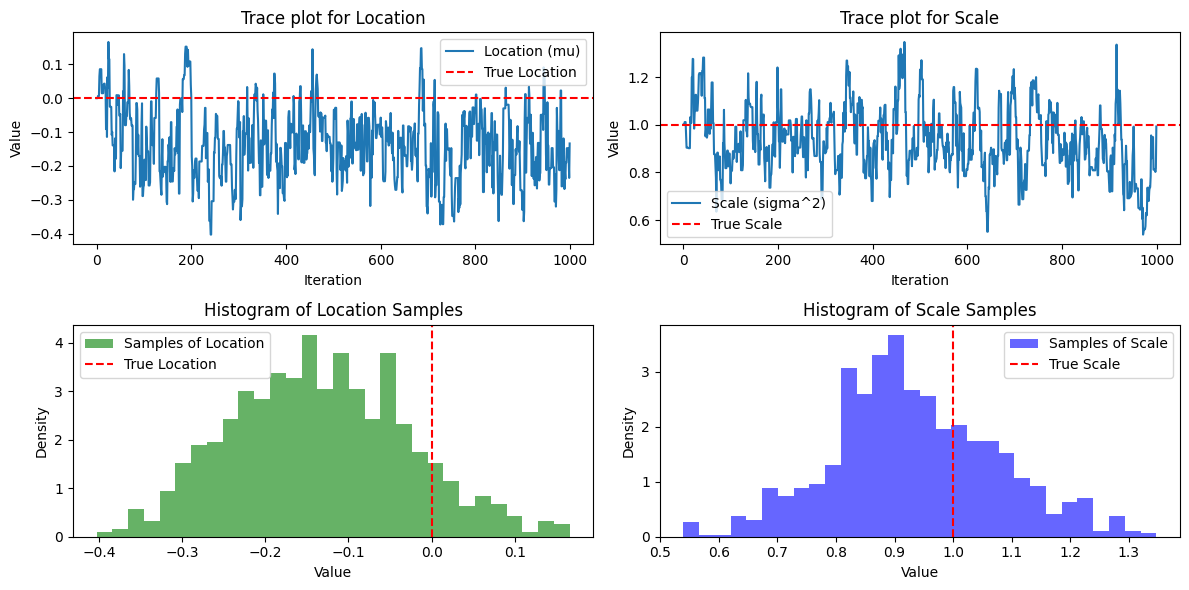

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the log-likelihood function
def log_likelihood(data, params):
    location, scale = params
    degrees_of_freedom = 5  # Fix degrees of freedom to a constant value (e.g., 5)
    return np.sum(stats.t.logpdf(data, df=degrees_of_freedom, loc=location, scale=np.sqrt(scale)))

# Define log-priors
def log_prior_location(location, location_prior=0, location_prior_scale=1):
    return stats.norm.logpdf(location, loc=location_prior, scale=np.sqrt(location_prior_scale))

def log_prior_scale(scale, scale_prior_scale=1):
    return stats.halfnorm.logpdf(np.sqrt(scale), scale=np.sqrt(scale_prior_scale))

# Log posterior
def log_posterior(data, params):
    return log_likelihood(data, params) + log_prior_location(params[0]) + log_prior_scale(params[1])

# Metropolis-Hastings step on a log-scale
def metropolis_step_log(data, params, proposal_std_location=0.1, proposal_std_scale=0.1):
    location, scale = params

    # Propose new values for the parameters
    proposed_location = np.random.normal(location, proposal_std_location)
    proposed_scale = np.abs(np.random.normal(scale, proposal_std_scale))  # Scale must be positive

    # Calculate the log posterior for the proposed and current values
    current_log_posterior = log_posterior(data, params)
    proposed_log_posterior = log_posterior(data, (proposed_location, proposed_scale))

    # Calculate the acceptance probability on the log scale
    log_acceptance = proposed_log_posterior - current_log_posterior

    # Accept or reject the new proposal
    if np.log(np.random.rand()) < log_acceptance:
        return proposed_location, proposed_scale, True  # Accepted
    else:
        return location, scale, False  # Rejected

# Metropolis-Hastings sampler
def metropolis_hastings(data, iterations=1000, params_init=(0, 1), proposal_std_location=0.1, proposal_std_scale=0.1):
    location, scale = params_init
    samples = np.zeros((iterations, 2))  # Store samples for location and scale

    for i in range(iterations):
        location, scale, accepted = metropolis_step_log(data, (location, scale), proposal_std_location, proposal_std_scale)

        # Store the sample (location, scale)
        samples[i] = [location, scale]

    return samples

# Example usage
np.random.seed(42)
# Simulate some data from a t-distribution with known parameters
true_location = 0
true_scale = 1
true_degrees_of_freedom = 5  # Degrees of freedom is fixed to 5
n = 100
data = stats.t.rvs(df=true_degrees_of_freedom, loc=true_location, scale=np.sqrt(true_scale), size=n)

# Run the Metropolis-Hastings sampler
iterations = 1000
samples = metropolis_hastings(data, iterations=iterations)

# Visualization

# Trace plot
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(samples[:, 0], label="Location (mu)")
plt.title('Trace plot for Location')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.axhline(true_location, color='r', linestyle='--', label='True Location')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(samples[:, 1], label="Scale (sigma^2)")
plt.title('Trace plot for Scale')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.axhline(true_scale, color='r', linestyle='--', label='True Scale')
plt.legend()

# Histogram of the samples
plt.subplot(2, 2, 3)
plt.hist(samples[:, 0], bins=30, density=True, alpha=0.6, color='g', label="Samples of Location")
plt.axvline(true_location, color='r', linestyle='--', label='True Location')
plt.title('Histogram of Location Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(samples[:, 1], bins=30, density=True, alpha=0.6, color='b', label="Samples of Scale")
plt.axvline(true_scale, color='r', linestyle='--', label='True Scale')
plt.title('Histogram of Scale Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


# Q2

Output()

<Figure size 1000x600 with 0 Axes>

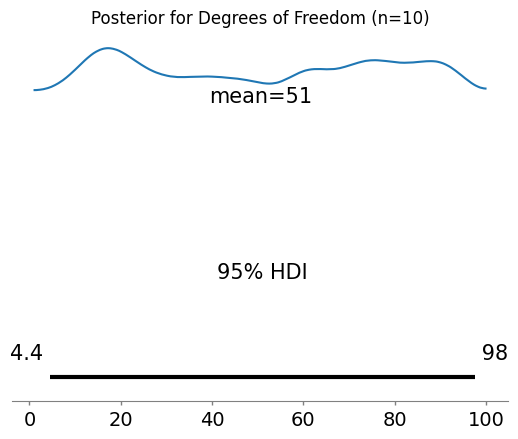

Summary for Sample Size 10:
      mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
df  50.552  28.534     4.442     97.571      0.488    0.345    2752.0   

    ess_tail  r_hat  
df    1835.0    1.0  

--------------------------------------------------


Output()

<Figure size 1000x600 with 0 Axes>

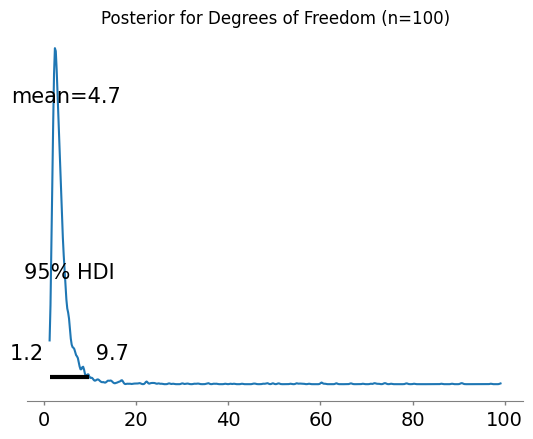

Summary for Sample Size 100:
    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
df  4.72  7.596     1.248      9.697       0.34    0.241    1289.0     861.0   

    r_hat  
df    1.0  

--------------------------------------------------


Output()

<Figure size 1000x600 with 0 Axes>

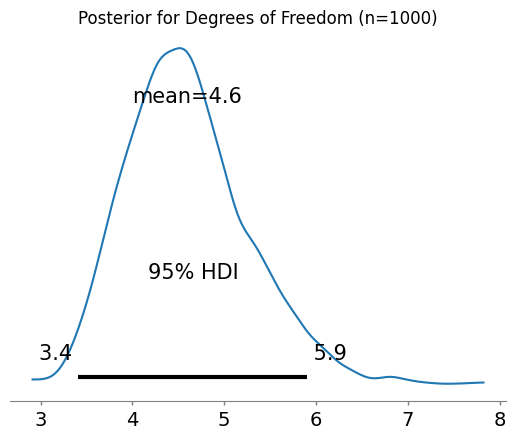

Summary for Sample Size 1000:
     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
df  4.594  0.661     3.412      5.906      0.013    0.009    2613.0    2841.0   

    r_hat  
df    1.0  

--------------------------------------------------


Output()

<Figure size 1000x600 with 0 Axes>

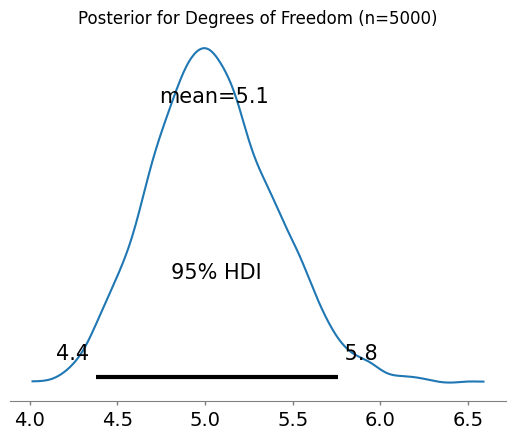

Summary for Sample Size 5000:
     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
df  5.051  0.361     4.377      5.756      0.008    0.006    2093.0    2065.0   

    r_hat  
df    1.0  

--------------------------------------------------


In [23]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Fix the true parameters for the Student's t-distribution
true_location = 0
true_scale = 1
true_degrees_of_freedom = 5

# Function to simulate data
def generate_data(n, df, loc=0, scale=1):
    return np.random.standard_t(df, size=n) * scale + loc

# Function to run PyMC model and infer degrees of freedom
def run_pymc_model(data, sample_size):
    with pm.Model() as model:
        # Priors for location and scale
        location = pm.Normal('location', mu=0, sigma=10)
        scale = pm.HalfNormal('scale', sigma=10)

        # Degrees of freedom with a prior between 1 and 100
        df = pm.Uniform('df', lower=1, upper=100)

        # Likelihood (Student's t-distribution)
        likelihood = pm.StudentT('y', mu=location, sigma=scale, nu=df, observed=data)

        # Inference: sample using MCMC
        trace = pm.sample(2000, tune=1000, return_inferencedata=True)  # Important to return InferenceData

    return trace

# Explore inference on df for different sample sizes
sample_sizes = [10,100,1000, 5000]  # sample sizes list
traces = {}

for n in sample_sizes:
    # Generate data
    data = generate_data(n, true_degrees_of_freedom, true_location, true_scale)

    # Run the PyMC model
    trace = run_pymc_model(data, n)
    traces[n] = trace

    # Plot the posterior distributions for the degrees of freedom
    plt.figure(figsize=(10, 6))
    az.plot_posterior(trace, var_names=['df'], hdi_prob=0.95)
    plt.title(f'Posterior for Degrees of Freedom (n={n})')
    plt.show()

    # Display the summary using arviz.summary() for the parameter 'df'
    summary = az.summary(trace, var_names=['df'], hdi_prob=0.95)
    print(f"Summary for Sample Size {n}:")
    print(summary)
    print("\n" + "-"*50)


# Consulsion
From the different sizes we can see that for the model , the larger the sample size the more effective it is at estimating. For example , when looking at the HDI intervals for the different sample sizes , the sample (n=10) has a very wide range from 4.442 to 97.571 , indicating uncertainty about the parameter. Yet for larger n such as 100, 1000 and 5000 the range decreases significanlty , like when n=5000 range goes from 4.377 to 5.756. Showing that the larger the sample size the more effective the model is going to be at estimating the parameter .

# Q3